In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nir-generated-answers/generated_results_with_f1_llama2_chegeka.csv
/kaggle/input/nir-generated-answers/ruopenbookqa_gemma_generated_results.csv
/kaggle/input/nir-generated-answers/rudetox-nir (1).ipynb
/kaggle/input/nir-generated-answers/chgk_generated_results_with_f1_mistral.csv
/kaggle/input/nir-generated-answers/ruopenbookqa_vikhr_generated_results.csv
/kaggle/input/nir-generated-answers/Llama2_rutedox_generated_results.csv
/kaggle/input/nir-generated-answers/ruopenbookqa_tinyllama_generated_results.csv
/kaggle/input/nir-generated-answers/ruopenbookqa_mistral_generated_results.csv
/kaggle/input/nir-generated-answers/chgk_generated_results_Gemma.csv
/kaggle/input/nir-generated-answers/chgk_generated_results_tinyLlama.csv
/kaggle/input/nir-generated-answers/rudetox_Vikhr_generated_results.csv
/kaggle/input/nir-generated-answers/rudetox_Mistral_generated_results.csv
/kaggle/input/nir-generated-answers/chgk_generated_results_with_f1_gemma.csv
/kaggle/input/nir-generated-an

In [5]:
gm = "/kaggle/input/gemma/transformers/2b/2"
mistral = '/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1'
llama2 = '/kaggle/input/llama-2/pytorch/7b-hf/1'
vikhr = 'Vikhrmodels/Vikhr-7B-instruct_merged'
tinyllama = 'TinyLlama/TinyLlama-1.1B-Chat-v1.0'

In [2]:
!pip -q install shap transformers datasets
!pip install langchain
!pip install langchain
!pip install peft
!pip install trl
!pip install shap

!pip install -q -U transformers
!pip install -q accelerate
!pip install -q -i https://pypi.org/simple/ bitsandbytes
!pip install -q -U datasets
!pip install shap
# !pip install lime
# !pip install lit-nlp

import warnings
warnings.filterwarnings("ignore")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 779.8 kB/s eta 0:00:00:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 5.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.5/308.5 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.8/122.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
  Attempting uninstall: orjson
    Found existing installation: orjson 3.9.10
    Uninstalling orjson-3.9.10:
      Successfully uninstalled orjson-3.9.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 r

In [6]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import torch
import torch.nn as nn

import transformers
from transformers import (AutoModelForCausalLM, 
                          AutoTokenizer, 
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                          pipeline, 
                          logging)
from datasets import Dataset
from peft import LoraConfig, PeftConfig
import bitsandbytes as bnb

from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix)
from sklearn.model_selection import train_test_split
import shap
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re

# Calculating Accuracy of models

In [52]:
import pandas as pd

df_gemma = pd.read_csv('/kaggle/input/nir-generated-answers/ruopenbookqa_gemma_generated_results.csv')
df_mistral = pd.read_csv('/kaggle/input/nir-generated-answers/ruopenbookqa_mistral_generated_results.csv')
df_tinyllama = pd.read_csv('/kaggle/input/nir-generated-answers/ruopenbookqa_tinyllama_generated_results.csv')
df_vikhr = pd.read_csv('/kaggle/input/nir-generated-answers/ruopenbookqa_vikhr_generated_results.csv')
df_llama2 = pd.read_csv('/kaggle/input/nir-generated-answers/Llama2_ruopenbookqa_generated_results.csv')

df_mistral.head()


,question,prompt,expected_answer,generated_text
0,Причиной какого явления может быть вырубка леса?,"Причиной какого явления может быть вырубка леса?\nA) глобальное потепление\nB) гибель океанов\nC) солевые растворы\nD) гибель деревьев\nКакой ответ является правильным? Запишите только букву верного варианта: A, B, C или D.\nОтвет:",D,\nA) глобальное потепление
1,Причиной какого явления может быть вырубка леса?,"Причиной какого явления может быть вырубка леса?\nA. глобальное потепление\nB. гибель океанов\nC. солевые растворы\nD. гибель деревьев\nКакой ответ является правильным? Запишите только букву верного варианта: A, B, C или D.\nОтвет:",D,\nA. глобальное потепление
2,Причиной какого явления может быть вырубка леса?,"Причиной какого явления может быть вырубка леса?\nA) глобальное потепление\nB) гибель океанов\nC) солевые растворы\nD) гибель деревьев\nКакой ответ является правильным? В качестве ответа запишите только букву верного варианта: A, B, C или D без дополнительных объяснений.\nОтвет:",D,\nA) глобальное потепление
3,Причиной какого явления может быть вырубка леса?,"Причиной какого явления может быть вырубка леса?\nA. глобальное потепление\nB. гибель океанов\nC. солевые растворы\nD. гибель деревьев\nКакой ответ является правильным? В качестве ответа запишите только букву верного варианта: A, B, C или D без дополнительных объяснений.\nОтвет:",D,\nA. глобальное потепление
4,Причиной какого явления может быть вырубка леса?,"Опираясь на логику и общеизвестные факты, ответьте на вопрос: Причиной какого явления может быть вырубка леса?\nA) глобальное потепление\nB) гибель океанов\nC) солевые растворы\nD) гибель деревьев\nВ качестве ответа запишите только букву верного варианта: A, B, C или D без дополнительных объяснений.\nОтвет:",D,\nA) глобальное потепление


In [3]:
pd.set_option('display.max_colwidth', None)

print(df_mistral['question'][:10])
print(df_mistral['prompt'][:10])
print(df_mistral['generated_text'][:10])

0    Причиной какого явления может быть вырубка леса?
1    Причиной какого явления может быть вырубка леса?
2    Причиной какого явления может быть вырубка леса?
3    Причиной какого явления может быть вырубка леса?
4    Причиной какого явления может быть вырубка леса?
5    Причиной какого явления может быть вырубка леса?
6    Причиной какого явления может быть вырубка леса?
7    Причиной какого явления может быть вырубка леса?
8    Причиной какого явления может быть вырубка леса?
9    Причиной какого явления может быть вырубка леса?
Name: question, dtype: object
0                                                                                 Причиной какого явления может быть вырубка леса?\nA) глобальное потепление\nB) гибель океанов\nC) солевые растворы\nD) гибель деревьев\nКакой ответ является правильным? Запишите только букву верного варианта: A, B, C или D.\nОтвет: 
1                                                                                 Причиной какого явления может быт

In [53]:
def extract_first_letter(text):
    match = re.search(r'([ABCD])[\).]?\s?(.*)', text, re.DOTALL)
    if match:
        return match.group(1)
    else:
        return text

dataframes = {
    "mistral": {"df": df_mistral, "column": "generated_text"},
    "tinyllama": {"df": df_tinyllama, "column": "generated_text"},
    "gemma": {"df": df_gemma, "column": "generated_text"}, 
    "vikhr": {"df": df_vikhr, "column": "generated_text"},
    "llama2": {"df": df_llama2, "column": "generated_text"},
}


In [55]:
for name, info in dataframes.items():
    df = info["df"]
    column = info["column"]

    df[column] = df[column].apply(extract_first_letter)

    print(f"Head of {name} after processing:")
    print(df.head())

Head of mistral after processing:
                                           question  \
0  Причиной какого явления может быть вырубка леса?   
1  Причиной какого явления может быть вырубка леса?   
2  Причиной какого явления может быть вырубка леса?   
3  Причиной какого явления может быть вырубка леса?   
4  Причиной какого явления может быть вырубка леса?   

                                                                                                                                                                                                                                                                                                                  prompt  \
0                                                                               Причиной какого явления может быть вырубка леса?\nA) глобальное потепление\nB) гибель океанов\nC) солевые растворы\nD) гибель деревьев\nКакой ответ является правильным? Запишите только букву верного варианта: A, B, C или D.\nОтвет:    
1  

Mistral Accuracy score: 0.29
Tinyllama Accuracy score: 0.18
Gemma Accuracy score: 0.11
Vikhr Accuracy score: 0.52
Llama2 Accuracy score: 0.20


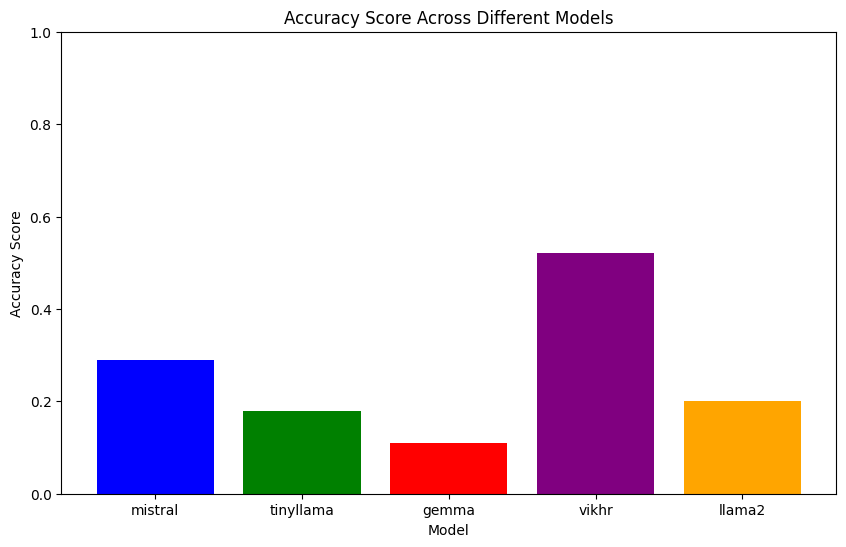

In [56]:
# Process each dataframe to extract the first letter
accuracy_scores = {}
for name, info in dataframes.items():
    df = info["df"]
    column = info["column"]

    df[column] = df[column].apply(extract_first_letter)

    accuracy = calculate_accuracy(df.copy())
    accuracy_scores[name] = accuracy
    print(f"{name.capitalize()} Accuracy score: {accuracy:.2f}")

# Plotting accuracy scores
plt.figure(figsize=(10, 6))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color=['blue', 'green', 'red', 'purple', 'orange'])

plt.title('Accuracy Score Across Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1) 

plt.show()

# Calculating Answer Variability

In [ ]:
# This function calculates the mean cosine similarity for all formats of a single question.

def preprocess_text(text):
    text = re.sub(r'\n', '', text)  
    text = text.strip()  
    return text.lower()

def calculate_mean_cosine_similarity_for_question(df):
    vectorizer = CountVectorizer()
    X_generated = vectorizer.fit_transform(df['generated_text'])
    X_prompt = vectorizer.transform(df['prompt'])

    cos_sim_matrix = cosine_similarity(X_generated, X_prompt)
    mean_cosine_similarity = cos_sim_matrix.diagonal().mean()
    
    return mean_cosine_similarity


In [42]:
def calculate_overall_variability(dataframes):
    question_variabilities = []

    for df in dataframes:
        question_ids = df['question'].unique()
        question_means = []
        
        for question_id in question_ids:
            df_question = df[df['question'] == question_id]
            mean_cosine_similarity = calculate_mean_cosine_similarity_for_question(df_question)
            question_means.append(mean_cosine_similarity)
        
        question_variability = 1 - pd.Series(question_means).mean()
        question_variabilities.append(question_variability)
    
    overall_variability = pd.Series(question_variabilities).mean()
    
    return overall_variability

In [44]:
#Calculating Cosine Similarity 

dataframes = [df_gemma, df_mistral, df_tinyllama, df_vikhr, df_llama2]

variability_gemma = calculate_overall_variability([df_gemma])
variability_mistral = calculate_overall_variability([df_mistral])
variability_tinyllama = calculate_overall_variability([df_tinyllama])
variability_vikhr = calculate_overall_variability([df_vikhr])
variability_llama2 = calculate_overall_variability([df_llama2])

print("Gemma Answer Variability (Cosine Similarity):", variability_gemma)
print("Mistral Answer Variability (Cosine Similarity):", variability_mistral)
print("Tinyllama Answer Variability (Cosine Similarity):", variability_tinyllama)
print("Vikhr Answer Variability (Cosine Similarity):", variability_vikhr)
print("Llama2 Answer Variability (Cosine Similarity):", variability_llama2)


Gemma Answer Variability (Cosine Similarity): 0.6785516827667002
Mistral Answer Variability (Cosine Similarity): 0.5300681009649982
Tinyllama Answer Variability (Cosine Similarity): 0.6041279305651595
Vikhr Answer Variability (Cosine Similarity): 0.807780778271959
Llama2 Answer Variability (Cosine Similarity): 0.703075583256901


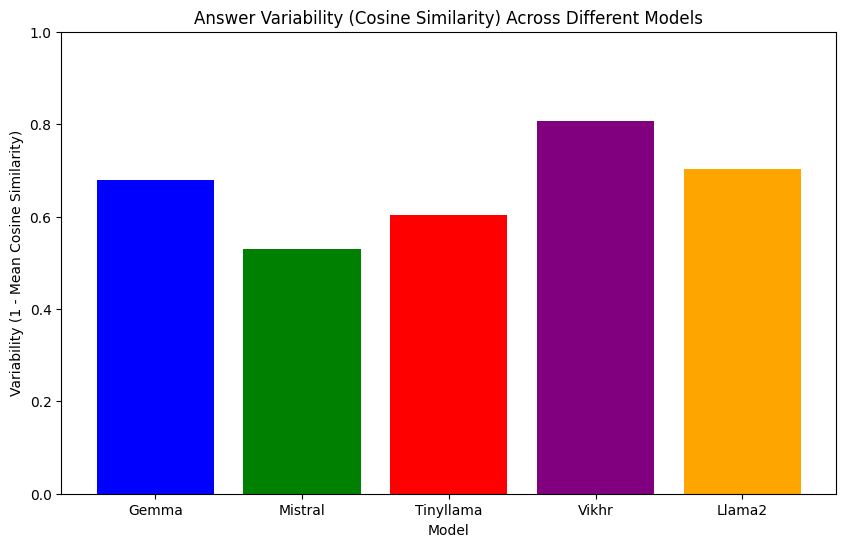

In [45]:
# Plotting Cosine Similarity

import matplotlib.pyplot as plt

model_names = ["Gemma", "Mistral", "Tinyllama", "Vikhr", "Llama2"]
variability_scores = [variability_gemma, variability_mistral, variability_tinyllama, variability_vikhr, variability_llama2]

plt.figure(figsize=(10, 6))
plt.bar(model_names, variability_scores, color=['blue', 'green', 'red', 'purple', 'orange'])

plt.title('Answer Variability (Cosine Similarity) Across Different Models')
plt.xlabel('Model')
plt.ylabel('Variability (1 - Mean Cosine Similarity)')
plt.ylim(0, 1) 

plt.show()

# SHAP

In [31]:
# set model decoder to true
model.config.is_decoder=True
# set text-generation params under task_specific_params
model.config.task_specific_params["text-generation"] = {
    "do_sample": True,
    "max_length": 50,
    "temperature": 0,
    "top_k": 50,
    "no_repeat_ngram_size": 2
  }
     

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")
model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

In [16]:
x = [
       "Причиной какого явления может быть вырубка леса?\nA. глобальное потепление\nB. гибель океанов\nC. солевые растворы\nD. гибель деревьев\nКакой ответ является правильным? Запишите только букву верного варианта: A, B, C или D.\nОтвет: "
]
     

y = [
    "2. C"
]

In [17]:
teacher_forcing_model = shap.models.TeacherForcing(model, tokenizer)
masker = shap.maskers.Text(tokenizer, mask_token = "...", collapse_mask_token=True)

explainer = shap.Explainer(teacher_forcing_model,masker)
shap_values = explainer(x, y)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:39, 39.20s/it]               


In [18]:
shap.plots.text(shap_values)


In [7]:
x = [
       "Причиной какого явления может быть вырубка леса?\nA. глобальное потепление\nB. гибель океанов\nC. солевые растворы\nD. гибель деревьев\nКакой ответ является правильным? Запишите только букву верного варианта: A, B, C или D.\nОтвет: "
]
     

y = [
    "2. C"
]

teacher_forcing_model = shap.models.TeacherForcing(model, tokenizer)
masker = shap.maskers.Text(tokenizer, mask_token = "...", collapse_mask_token=True)

explainer = shap.Explainer(teacher_forcing_model,masker)
shap_values_tinyllama = explainer(x, y)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [07:11, 431.23s/it]              


In [8]:
shap.plots.text(shap_values_tinyllama)


In [16]:
x = df['prompt'][0:10]
y = df['generated_text'][0:10]

In [17]:
teacher_forcing_model = shap.models.TeacherForcing(model, tokenizer)
masker = shap.maskers.Text(tokenizer, mask_token = "...", collapse_mask_token=True)

explainer = shap.Explainer(teacher_forcing_model,masker)
shap_values_all = explainer(x, y)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 1/10 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 3/10 [14:15<23:47, 203.92s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 4/10 [22:45<33:09, 331.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 5/10 [30:40<32:04, 384.93s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 6/10 [40:22<30:13, 453.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 7/10 [48:09<22:54, 458.07s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 8/10 [55:32<15:06, 453.25s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 9/10 [1:03:19<07:37, 457.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 10/10 [1:11:16<00:00, 463.69s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 11it [1:19:01, 474.13s/it]                        


In [19]:
shap_values_all

.values =
array([array([[0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              ...,
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.]]),
       array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                0.00000000e+00],
              [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                0.00000000e+00],
              [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                0.00000000e+00],
              [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                0.00000000e+00],
              [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                0.00000000e+00],
              [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                0.00000000e+00],
              [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                0.00000000e+00],
      